In [462]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import(
    train_test_split,
    cross_val_score,
)

from sklearn.linear_model import(
    LassoCV
)

from sklearn.feature_selection import(
    VarianceThreshold,
    chi2,
    SelectKBest,
)


#   Inter-Notebook Loader 
###  This code will load other notebooks in the same directory

In [452]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        print("No path")
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % self.path)

        # load the notebook object
        with io.open(self.path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [453]:
feature_transform_path = os.getcwd() + "/feature_transform.ipynb"
nb = NotebookLoader(path=feature_transform_path)

In [454]:
feature_transform = nb.load_module(feature_transform_path)

importing Jupyter notebook from /Users/deangoldman/class/nycdsa/Housing/feature_transform.ipynb


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:3855: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [455]:
df = feature_transform.train_numeric
train = feature_transform.train

# Mapping ordered categorical variables
Some of the features in the data set are categorically ordered i.e; Excellent, Good, Fair,...  
To have a label encoding consistent with category meanings, run this mapping.  
Otherwise you will get something like this:  
  
     
"Good" = 4  
"Average" = 5  
"Excellent" = 1  
"Poor" = 2  
  
This affects variable correlation- and I bet it also affects variable importance during modeling.  
To see this demonstrated: Don't run the code below, and notice in the correlation plot that "ExterQual" is inversely correlated with "OverallQual" and "SalePrice"- which makes no sense.

In [458]:
for i in range(len(train.columns)-1):
    is_cat = train.iloc[:,i].values.any() in ("Gd","Ex","TA","Fa","Po")
    if is_cat == True:
        train[train.columns[i]] = train[train.columns[i]].map({"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1})
        df[train.columns[i]] = train[train.columns[i]]

In [459]:
neg = df.corr()[df.corr() < -0.5]
neg = neg.dropna(how="all", axis=1)
neg = neg.dropna(how="all", axis=0)
pos = df.corr()[df.corr() > 0.5]
pos = pos[pos < 1.0]
pos = pos.dropna(how="all", axis=1)
pos = pos.dropna(how="all", axis=0)

/Users/deangoldman/Library/Python/3.6/lib/python/site-packages/matplotlib/artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


[None]

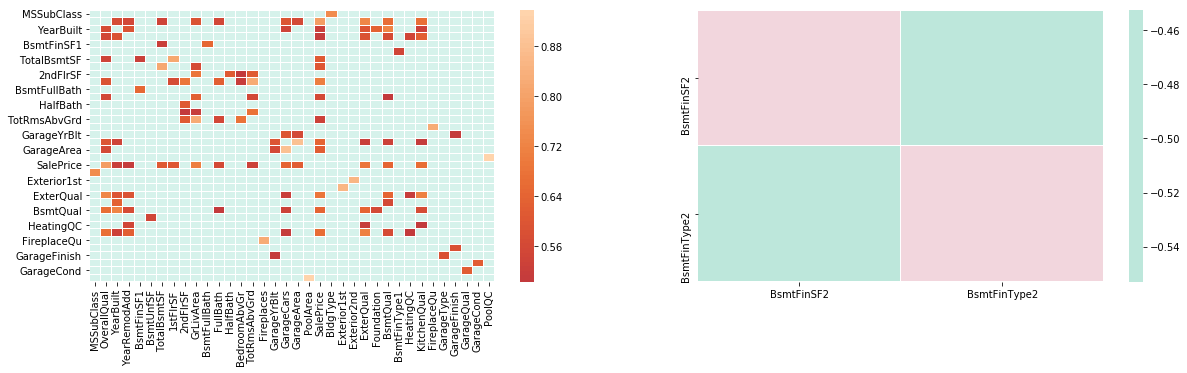

In [460]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))
pos_heatmap = sns.heatmap(pos, center=0, linewidths=0.01, ax=axs[0])
pos_heatmap.set(axis_bgcolor="#D6F2EB")
neg_heatmap = sns.heatmap(neg, center=0, linewidths=0.01, ax=axs[1])
neg_heatmap.set(axis_bgcolor="#F2D6DD")

In [306]:
# le = LabelEncoder()
# le.fit(train["KitchenQual"])
# list(le.classes_)
# tdf = pd.DataFrame([le.transform(train["KitchenQual"]),
#                    train["KitchenQual"],
#                    train["SalePrice"]]).T
# tdf.rename(columns={0:"Encoded", 1:"Original", 2:"SalePrice"}, inplace=True)

/Users/deangoldman/Library/Python/3.6/lib/python/site-packages/matplotlib/artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


[None]

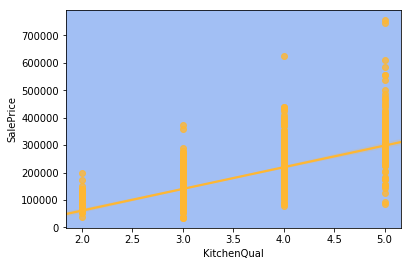

In [461]:
# Example plot
regplot = sns.regplot(x = 'KitchenQual', y = 'SalePrice', data = df, color = '#FFB733')
regplot.set(axis_bgcolor="#A2BFF4")

In [471]:
X = df.loc[:, df.columns != 'SalePrice']
y = df["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [481]:
# Variance Threshold
# Not sure how to incorporate this quite yet.

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

array([[  1.00000000e+00,   6.00000000e+01,   6.50000000e+01, ...,
          1.00000000e+00,   1.00000000e+01,   6.00000000e+00],
       [  2.00000000e+00,   2.00000000e+01,   8.00000000e+01, ...,
          1.00000000e+00,   1.00000000e+01,   6.00000000e+00],
       [  3.00000000e+00,   6.00000000e+01,   6.80000000e+01, ...,
          1.00000000e+00,   1.00000000e+01,   6.00000000e+00],
       ..., 
       [  1.45800000e+03,   7.00000000e+01,   6.60000000e+01, ...,
          4.00000000e+00,   1.00000000e+01,   6.00000000e+00],
       [  1.45900000e+03,   2.00000000e+01,   6.80000000e+01, ...,
          1.00000000e+00,   1.00000000e+01,   6.00000000e+00],
       [  1.46000000e+03,   2.00000000e+01,   7.50000000e+01, ...,
          1.00000000e+00,   1.00000000e+01,   6.00000000e+00]])

In [ ]:
# PCA workflow not being used atm.

# pca = PCA()
# # scaled_data = scale(X_train.T)
# # pca.fit(scaled_data)    

# pca.fit(scale(X_train))
# pca_data = pca.transform(scale(X_train))

# per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
# labels = ["PC" + str(x) for x in range(1, len(per_var) + 1)]
# plt.bar(left=range(1,6), height=per_var[:5], tick_label=labels[:5])
# plt.show()

# pca_df = pd.DataFrame(pca_data)
# plt.scatter(pca_df[0], pca_df[1], pca_df[3], c=["red","blue","green"])